# Applied DS 2 - Keras 
The sections are:

1. Data Processing
2. Model Definition
3. Model Training
4. Model Evaluation

In [31]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix as cf_

from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [12]:
# CodeGrade Tag Init1
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing



In [13]:


label_dict = {'cat' : 0,
              'dog' : 1,
              'wild' : 2}

# This function is provided to read in the image files from the folder on your
# Google Drive
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]
  label = tf.strings.to_number(label)

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

img_loc = "/content/drive/MyDrive/Animals/"

train_list_ds = tf.data.Dataset.list_files(img_loc + "train/*/*")
valid_list_ds = tf.data.Dataset.list_files(img_loc + "val/*/*")


**Create a function called "img_process" converts the images to float32 datatype and resizes them to 64x64 pixels.**

In [14]:

### Write a function called img_process, which takes in the image and label as
### inputs, converts the data type of the image to tf.float32, resizes the
### image to (64,64), and finally returns the image and labels.


def img_process(image, label):

    image = tf.image.convert_image_dtype(image, tf.float32) # Convert image data type
    image = tf.image.resize(image, [64, 64]) #resize the image to (64, 64)

    return image, label



**Using the tf.data API, load in the training and validation data. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [15]:

### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 128. Use techniques like caching and
### prefetching to efficiently load the data.


# Loading and preprocessing training data
train_ds = train_list_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(img_process, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()  # for faster access
train_ds = train_ds.shuffle(buffer_size=1000)  # Shuffle the dataset to introcude randomness in training
train_ds = train_ds.batch(128)  # Batch data
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for faster loading

# Loading and preprocessing validation data
valid_ds = valid_list_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.map(img_process, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(128)
valid_ds = valid_ds.cache()
valid_ds = valid_ds.prefetch(buffer_size=tf.data.AUTOTUNE)



# Model Definition

**Using the Keras Functional API, create a convolutional neural network with the architecture show in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a SoftMax activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        1216      
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 GlobalPool (GlobalAverageP  (None, 128)               0         
 ooling2D)                                                       
                                                                 
 FC1 (Dense)                 (None, 512)               66048     
                                                                 
 Output (Dense)              (None, 10)                5130      
                                                                 
=================================================================
Total params: 363146 (1.39 MB)
Trainable params: 363146 (1.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [16]:

### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

# Input layer
input_layer = layers.Input(shape=(64, 64, 3), name='Input')

# Convolutional layers
conv0 = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', name='Conv0')(input_layer)
conv1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='Conv1')(conv0)
conv2 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='Conv2')(conv1)

pool1 = layers.MaxPooling2D(pool_size=(2, 2), name='Pool1')(conv2)

conv3 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='Conv3')(pool1)
conv4 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='Conv4')(conv3)

pool2 = layers.MaxPooling2D(pool_size=(2, 2), name='Pool2')(conv4)

conv5 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='Conv5')(pool2)
conv6 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='Conv6')(conv5)

global_pool = layers.GlobalAveragePooling2D(name='GlobalPool')(conv6)

# Fully connected layers
fc1 = layers.Dense(512, activation='relu', name='FC1')(global_pool)

# Output layer
output_layer = layers.Dense(3, activation='softmax', name='Output')(fc1)

# Creating the model
model = Model(inputs=input_layer, outputs=output_layer)

In [17]:

### Print the model summary and confirm is has the same architecture as the one
### provided.

# model summary
model.summary() # adjusted output units to 3 as per added assignment instructions

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 64, 64, 16)        448       
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 64, 64, 32)        9248      
                                                                 
 Pool1 (MaxPooling2D)        (None, 32, 32, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 32, 32, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 32, 32, 64)        3692

**Compile the model using the Adam Optimizer with a learning rate of ```5e-5```, ```sparse categorical crossentropy``` loss function, and ```accuracy``` metric.**

In [18]:


# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model Training

**Create a Model Checkpoint Callback that saves the weights of the best performing epoch, based on the validation accuracy.**

In [19]:

### Create a ModelCheckpoint callback to store the bext weights from the model,
### based on the validation accuracy. Call this callback "checkpoint_callback"

checkpoint_filepath = '/content/checkpoint'


# Defining the checkpoint callback
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_best_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      verbose=1)

**Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [20]:

### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

# Defining the LearningRateScheduler callback
lr_callback = LearningRateScheduler(scheduler)

**Train the model for 100 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [21]:

### Train the model for 100 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

# Training the model and storing a history object
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=valid_ds,
                    callbacks=[checkpoint_callback, lr_callback])
history

Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 1.0869 - accuracy: 0.4027 
Epoch 1: val_accuracy improved from -inf to 0.44667, saving model to /content/checkpoint
115/115 [==============================] - 1210s 9s/step - loss: 1.0869 - accuracy: 0.4027 - val_loss: 1.0509 - val_accuracy: 0.4467 - lr: 5.0000e-05
Epoch 2/100
114/115 [============================>.] - ETA: 0s - loss: 0.9805 - accuracy: 0.5019
Epoch 2: val_accuracy improved from 0.44667 to 0.46733, saving model to /content/checkpoint
115/115 [==============================] - 6s 56ms/step - loss: 0.9804 - accuracy: 0.5020 - val_loss: 0.9710 - val_accuracy: 0.4673 - lr: 5.0000e-05
Epoch 3/100
114/115 [============================>.] - ETA: 0s - loss: 0.8728 - accuracy: 0.5530
Epoch 3: val_accuracy improved from 0.46733 to 0.59800, saving model to /content/checkpoint
115/115 [==============================] - 7s 62ms/step - loss: 0.8727 - accuracy: 0.5529 - val_loss: 0.8370 - val_accuracy: 0.5980 - lr

# Model Evaluation

**Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the models performance.**

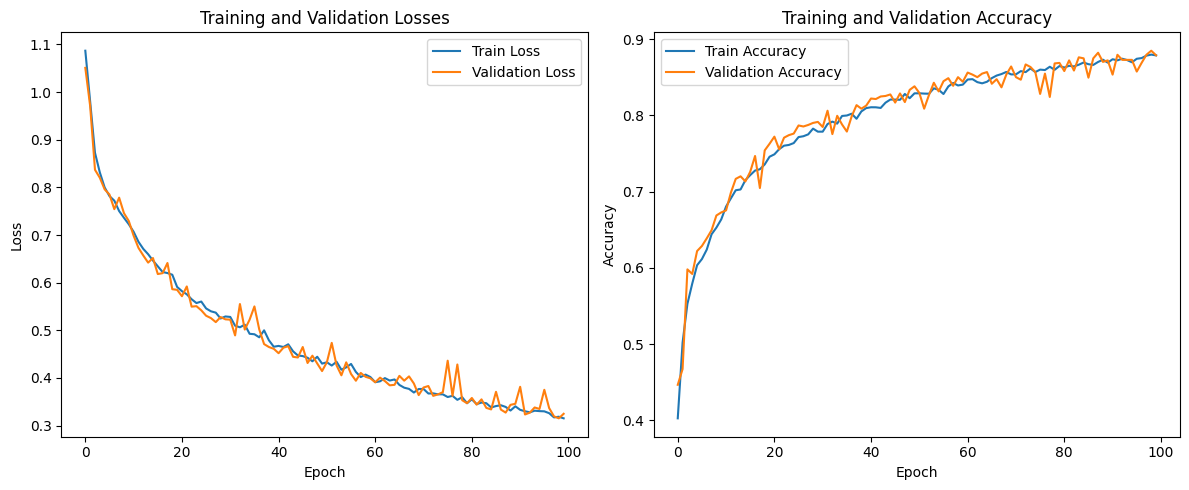

In [22]:



# creating plots

# get training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# plot training and validation losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**Load the best weights from your model checkpoint, and create plots demonstrating the classification perfomnce for all three classes. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

12/12 [==============================] - 6s 419ms/step
Confusion Matrix:
                 Predicted Cats  Predicted Dogs  Predicted Wildlife
Actual Cats                 174             166                 160
Actual Dogs                 172             172                 156
Actual Wildlife             169             174                 157


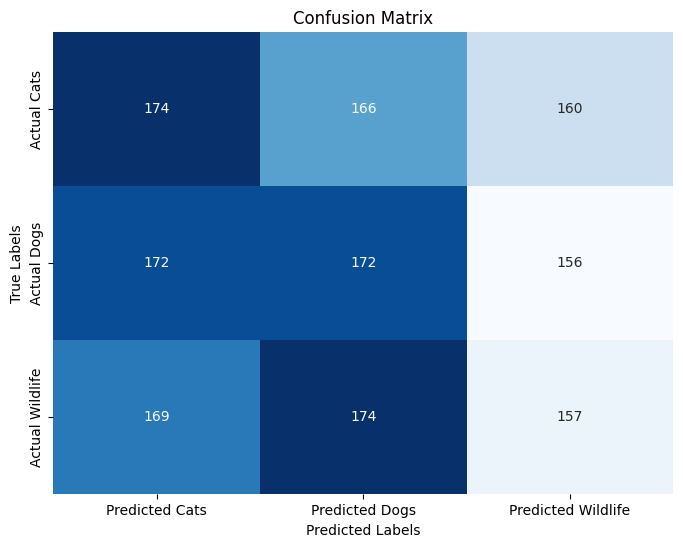

In [32]:


# loading the best weights from the model checkpoint
model.load_weights(checkpoint_filepath)

# creating dataset for prediction
prediction_ds = valid_list_ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
prediction_ds = prediction_ds.map(img_process, num_parallel_calls=tf.data.AUTOTUNE)
prediction_ds = prediction_ds.batch(128)

#  predicting
predictions = model.predict(prediction_ds)

# extracting true labels
true_labels = []
for img, label in prediction_ds:
    true_labels.extend(label.numpy())

# convert predictions probabilities to class labels
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# creating and plotting confusion matrix
conf_matrix_result = cf_(true_labels, predicted_labels)

# creating dataFrame from the confusion matrix
conf_matrix_df_result = pd.DataFrame(conf_matrix_result, index=['Actual Cats', 'Actual Dogs', 'Actual Wildlife'],
                                      columns=['Predicted Cats', 'Predicted Dogs', 'Predicted Wildlife'])

# display the dataFrame
print("Confusion Matrix:")
print(conf_matrix_df_result)

# visualizing confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_result, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Cats', 'Predicted Dogs', 'Predicted Wildlife'],
            yticklabels=['Actual Cats', 'Actual Dogs', 'Actual Wildlife'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
